Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip '/content/gdrive/MyDrive/CNN_assignment.zip' -d '/content/gdrive/MyDrive/Dataset/'

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/gdrive/MyDrive/Dataset/Skin can

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

### Importing Skin Cancer Data


In [5]:
!ls

gdrive	sample_data


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

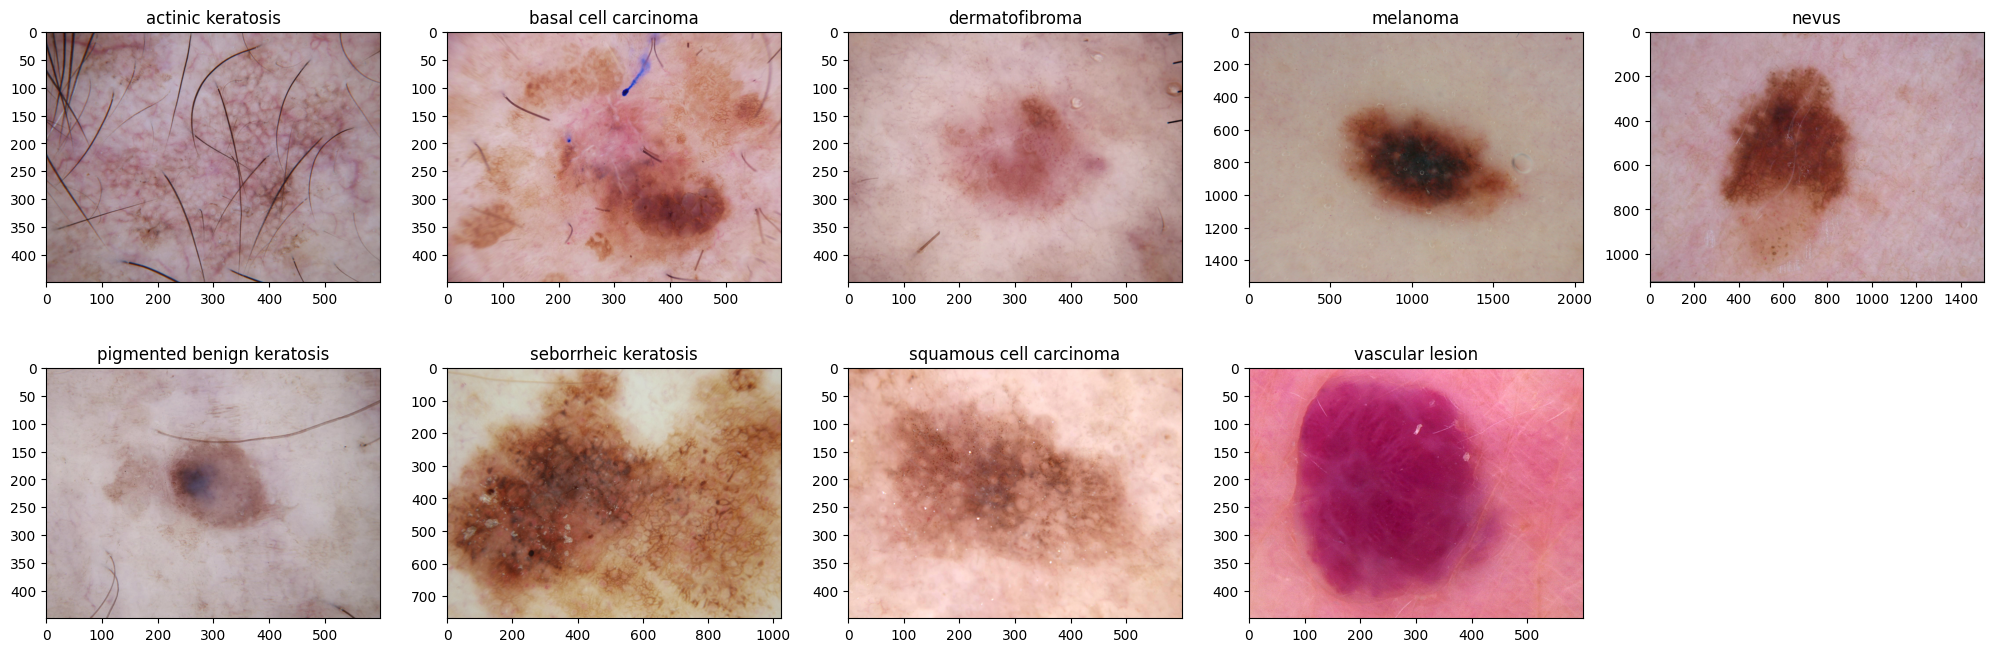

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [12]:
print(type(train_ds))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
32
32


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [14]:
# CNN Model

model =Sequential()

# scaling the pixel values from 0-255 to 0-1
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)            0

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 163ms/step - loss: 3.0588 - accuracy: 0.2176 - val_loss: 1.8352 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.8060 - accuracy: 0.3605 - val_loss: 1.6472 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5561 - accuracy: 0.4492 - val_loss: 1.6699 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 4s 72ms/step - loss: 1.4442 - accuracy: 0.4989 - val_loss: 1.4163 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.2240 - accuracy: 0.5703 - val_loss: 1.4463 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 4s 75ms/step - loss: 1.1868 - accuracy: 0.5887 - val_loss: 1.5632 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 4s 72ms/step - loss: 1.0611 - accuracy: 0.6283 - val_loss: 1.5393 - val_accuracy: 0.5302
Epoch 8/20


### Visualizing training results

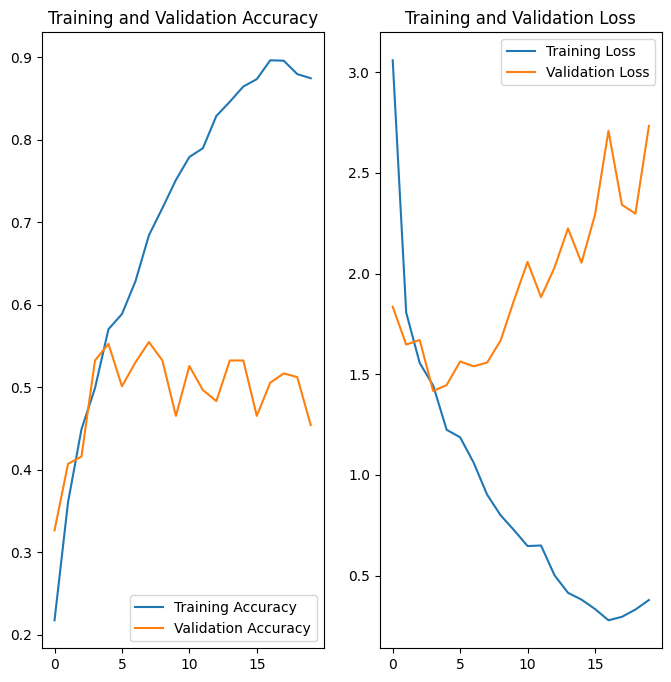

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy stall at 50% accuracy in training process.</li>
            <li>As the training loss dereases with epochs the validation loss increases.</li>
            <li>The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around <b>50%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>noticeable</b> which is a sign of overfitting.</li>
        </ol>
    </span>    
</div>

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

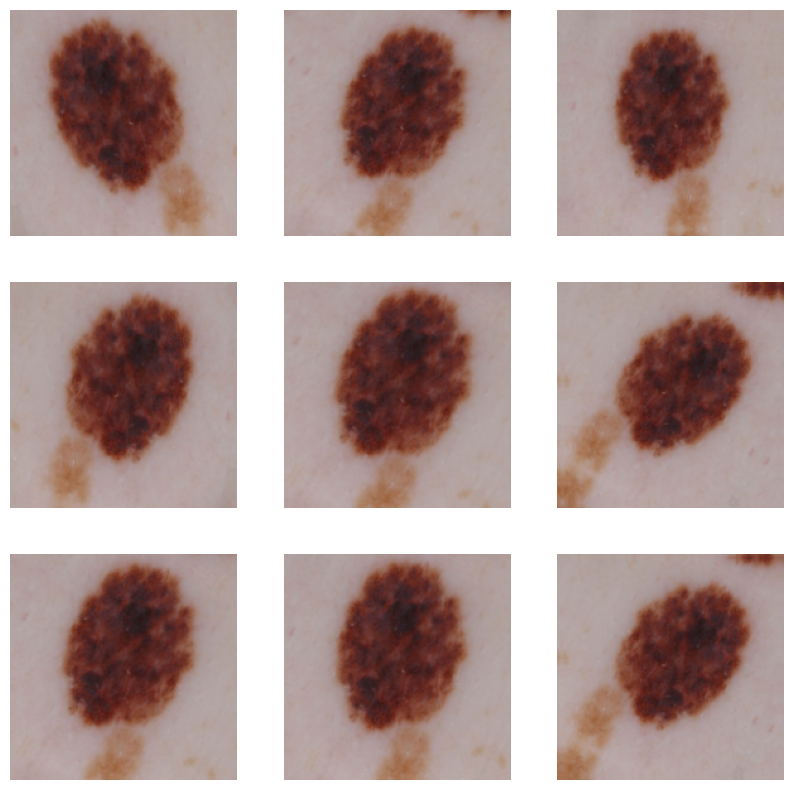

In [20]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [21]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))


### Compiling the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

### Training the model

In [23]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 77ms/step - loss: 3.5596 - accuracy: 0.1752 - val_loss: 2.0483 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 2.0347 - accuracy: 0.2160 - val_loss: 2.0080 - val_accuracy: 0.2282
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9548 - accuracy: 0.2506 - val_loss: 1.8958 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 1.7049 - accuracy: 0.3940 - val_loss: 1.6051 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.4448 - accuracy: 0.4894 - val_loss: 1.6109 - val_accuracy: 0.4183
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.3929 - accuracy: 0.5050 - val_loss: 1.4437 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 4s 74ms/step - loss: 1.4610 - accuracy: 0.4916 - val_loss: 1.4270 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing the results

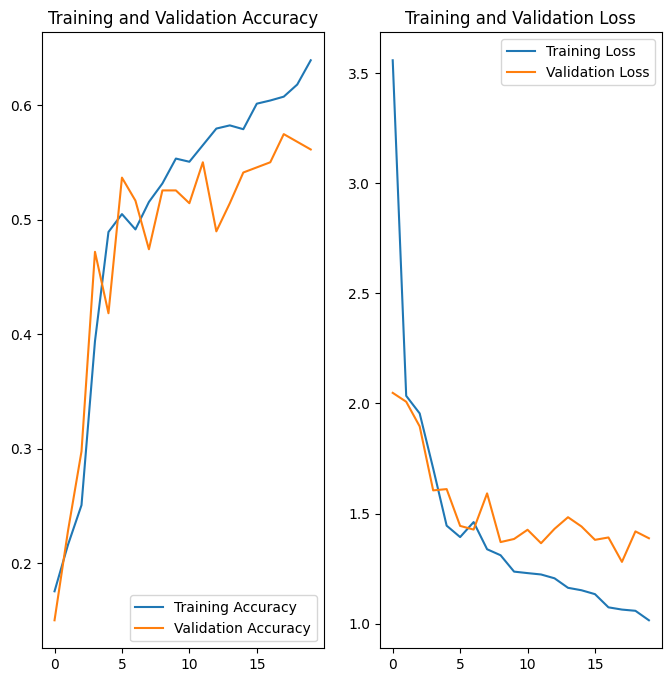

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
            <li>As the training loss decreases with epochs the validation loss decreases and stalls.</li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is still <b>slightly noticeable</b> which is a sign of overfitting.</li>
        </ol>
    </span>    
</div>

# Model Building & training on the augmented data with dropout :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [25]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [26]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [27]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 121ms/step - loss: 3.3964 - accuracy: 0.2126 - val_loss: 1.9320 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 6s 115ms/step - loss: 1.7631 - accuracy: 0.3733 - val_loss: 1.6144 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 6s 116ms/step - loss: 1.5519 - accuracy: 0.4475 - val_loss: 1.4842 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 6s 114ms/step - loss: 1.4252 - accuracy: 0.4888 - val_loss: 1.3842 - val_accuracy: 0.5481
Epoch 5/20
56/56 [==============================] - 6s 116ms/step - loss: 1.4021 - accuracy: 0.5039 - val_loss: 1.4543 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 6s 114ms/step - loss: 1.3956 - accuracy: 0.5084 - val_loss: 1.4650 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 6s 115ms/step - loss: 1.3352 - accuracy: 0.5268 - val_loss: 1.3597 - val_accuracy: 0.5436
Epoch 

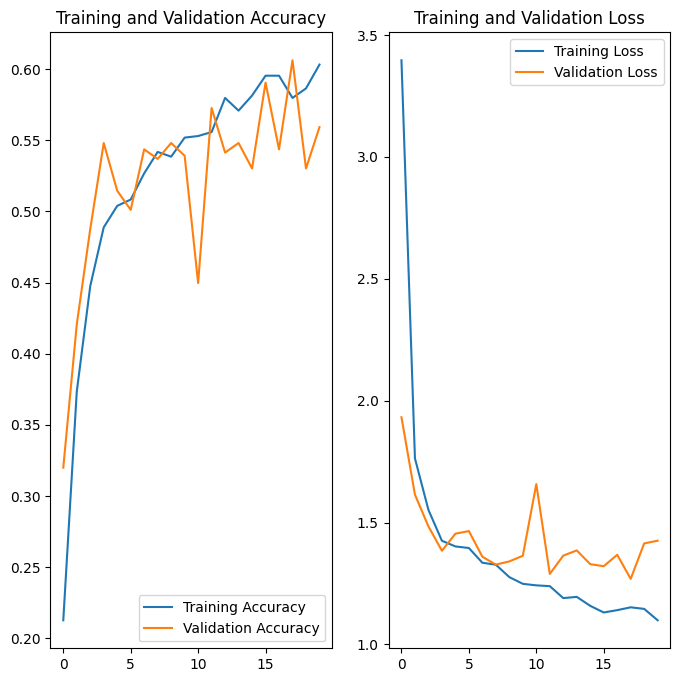

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
            <li><b>As the training loss decreases with epochs the validation loss decreases</b></li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
        </ol>
    </span>    
</div>

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

#### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>Which class has the least number of samples?<br>
            <b>seborrheic keratosis with 77 samples</b></li>
            <li>Which classes dominate the data in terms proportionate number of samples?<br>
            <b>pigmented benign keratosis with 462 samples</b></li>
        </ol>
    </span>    
</div>

# Handling class imbalances:



In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
## Getting error in path
##path_to_training_dataset="/content/gdrive/MyDrive/upgrad/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
##import Augmentor
##for i in class_names:
    ##p = Augmentor.Pipeline(path_to_training_dataset + i)
    ##p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    ##p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [36]:
path_to_training_dataset="/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

In [37]:
import Augmentor
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    print(f"Processing class: {class_name}")
    print(f"Class path: {class_path}")

    if not os.path.exists(class_path):
        print(f"Error: The directory {class_path} does not exist.")
        continue  # Skip to the next class if the directory does not exist
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.

print("Data augmentation completed.")

Processing class: actinic keratosis
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7823E00EE740>: 100%|██████████| 500/500 [00:19<00:00, 25.98 Samples/s]


Processing class: basal cell carcinoma
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7823FFF94310>: 100%|██████████| 500/500 [00:18<00:00, 27.11 Samples/s]


Processing class: dermatofibroma
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7823E01F79D0>: 100%|██████████| 500/500 [00:21<00:00, 23.41 Samples/s]


Processing class: melanoma
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7823FC4F37C0>: 100%|██████████| 500/500 [01:17<00:00,  6.44 Samples/s]


Processing class: nevus
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7823FC4DD870>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Processing class: pigmented benign keratosis
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7823E04280D0>: 100%|██████████| 500/500 [00:18<00:00, 26.74 Samples/s]


Processing class: seborrheic keratosis
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7823E00C3EB0>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]


Processing class: squamous cell carcinoma
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7823FFF94130>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Processing class: vascular lesion
Class path: /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7823FC6E78E0>: 100%|██████████| 500/500 [00:20<00:00, 24.85 Samples/s]

Data augmentation completed.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_2ef7c958-069f-4207-9964-2c964ba3e1b6.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_5de4580a-d6f0-408b-a3e3-31953498bce3.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_8d42c9aa-fbb7-41ae-8777-048d254fc71c.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029025.jpg_6633fc6f-7374-4b4b-8e41-6817d39e6180.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [43]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training on the rectified class imbalance data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.)

In [47]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### Compiling the model (Choosing optimizer and loss function appropriately)

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

#### Training the model

In [49]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 51s 276ms/step - loss: 2.5606 - accuracy: 0.2908 - val_loss: 1.6233 - val_accuracy: 0.3957
Epoch 2/30
169/169 [==============================] - 48s 276ms/step - loss: 1.6321 - accuracy: 0.3895 - val_loss: 1.5102 - val_accuracy: 0.4217
Epoch 3/30
169/169 [==============================] - 47s 269ms/step - loss: 1.4910 - accuracy: 0.4371 - val_loss: 1.4488 - val_accuracy: 0.4388
Epoch 4/30
169/169 [==============================] - 47s 269ms/step - loss: 1.3723 - accuracy: 0.4713 - val_loss: 1.3253 - val_accuracy: 0.5011
Epoch 5/30
169/169 [==============================] - 48s 273ms/step - loss: 1.3233 - accuracy: 0.4954 - val_loss: 1.2814 - val_accuracy: 0.5375
Epoch 6/30
169/169 [==============================] - 48s 268ms/step - loss: 1.2514 - accuracy: 0.5271 - val_loss: 1.2168 - val_accuracy: 0.5464
Epoch 7/30
169/169 [==============================] - 49s 282ms/step - loss: 1.2213 - accuracy: 0.5397 - val_loss: 1.1592 - val_ac

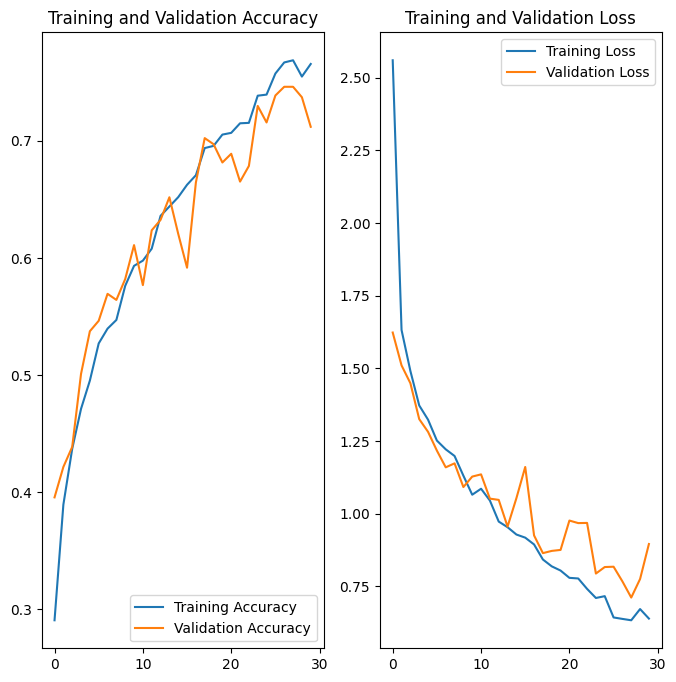

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.</li>
            <li>As the training loss decreases with epochs the validation loss also decreases.</li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around <b>75%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
            <li>The Model can be further improved by tuning the <b>hyperparameters</b></li>
        </ol>
    </span>    
</div>



<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <p> Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%. </p>  
    </span>    
</div>